In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Topic 0: standings/playoff news<br>
-  0.091: "game"
-  0.030: "cup"
-  0.026: "playoff"
-  0.023: "thread"
-  0.022: "2013"
-  0.019: "stanley"
-  0.017: "last"
-  0.016: "season"
-  0.015: "time"

Topic 1: contract/trade news<br>
-  0.042: "year"
-  0.023: "sign"
-  0.019: "goal"
-  0.017: "draft"
-  0.015: "2"
-  0.014: "deal"
-  0.012: "hit"

Topic 2: franchise news<br>
-  0.043: "team"
-  0.039: "fan"
-  0.023: "one"
-  0.020: "best"
-  0.018: "like"
-  0.016: "guy"
-  0.012: "look"
-  0.011: "trade"

Topic 3: individual news<br>
-  0.042: "player"
-  0.041: "new"
-  0.027: "team"
-  0.026: "jersey"
-  0.020: "r"
-  0.017: "anyone"
-  0.016: "league"
-  0.014: "xpost"
-  0.013: "get"

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# vectorize our processed_texts
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/text_data.csv')

# Vectorization

In [ ]:
# drop nan in df['preprocessed_title']
df = df.dropna(subset=['preprocessed_title'])
df = df.reset_index(drop=True)

# check if there are any nan values in df['preprocessed_title']
df['preprocessed_title'].isnull().sum()


np.int64(0)

In [ ]:
print(df['title'][505])
print(df['preprocessed_title'][505])
print(df['topic'][505])

avery: "blah blah blah... pay attention to me... blah blah blah"; suspended indefinitely
avery blah blah blah pay attention blah blah blah suspended indefinitely
1


In [ ]:
# Encode ProcessedTweet as vectors
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['preprocessed_title'])

X = X.toarray()

print(X.shape) # (number of samples, number of features)

(99844, 5000)


## Data Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, df['topic'], test_size=0.2, random_state=42)

In [ ]:
# Sample peek
sample = df.iloc[788]
print(sample['title'])
print(sample['preprocessed_title'])
print(sample['topic'])
print(X[25].sum()) # number of words in the sample

upper deck nhl rookie photo shoot
upper deck rookie photo shoot
1
10


In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Convert to long tensor for CrossEntropyLoss
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)  # Convert to long tensor for CrossEntropyLoss

# NN Architecture

In [ ]:
# Define the neural network architecture
class HockeyNN(nn.Module):
    def __init__(self, input_size=5000, hidden_size1=32, num_classes=4):
        super(HockeyNN, self).__init__()

        self.relu = nn.ReLU()  # activation function

        # Layer 1
        self.fc1 = nn.Linear(input_size, hidden_size1)

        # Layer 2
        self.fc2 = nn.Linear(hidden_size1, hidden_size1)

        # Dropout
        self.dropout = nn.Dropout(p=0.3)

        # Output Layer
        self.fc3 = nn.Linear(hidden_size1, num_classes)

        # Define the loss function
        self.loss_function = nn.CrossEntropyLoss()  # Suitable for multi-class classification with one-hot labels
    def forward(self, x):
        # Forward pass
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out
    # Define the loss function
    def loss_fn(self, y_pred, y_true):
        return self.loss_function(y_pred, y_true)

To prevent overfitting, the learning rate was reduced to 0.0001, weight decay was added to add regularization, as well as a dropout layer. The model didn't need a vast amount of complexity, only requiring 8 neurons in the activation layer to achieve an impressive validation accuracy without overfitting.

## Training

In [ ]:
# Create the model
model = HockeyNN(input_size=X.shape[1], hidden_size1=8, num_classes=len(df['topic'].unique()))
model.train()  # Set the model to training mode

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Adam optimizer with learning rate of 0.001


In [ ]:
# Train
num_epochs = 20
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

# Loss
train_loss = []
val_loss = []
# Accuracy
train_acc = [] # Do we care most about accuracy?
val_acc = []
# Recall
train_recall = []
val_recall = []
# Precision
train_precision = []
val_precision = []


for epoch in range(num_epochs):
    # Shuffle the training data
    indices = torch.randperm(len(X_train_tensor))
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_true_positive = 0
    epoch_false_negative = 0
    epoch_false_positive = 0

    for i in range(num_batches):
        # Get the batch
        X_batch = X_train_tensor[i * batch_size:(i + 1) * batch_size]
        y_batch = y_train_tensor[i * batch_size:(i + 1) * batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Compute the loss
        loss = model.loss_fn(y_pred, y_batch)
        epoch_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy, recall, and precision
        _, predicted = torch.max(y_pred.data, 1)
        epoch_train_correct += (predicted == y_batch).sum().item()

        true_positive = ((predicted == y_batch) & (y_batch == 1)).sum().item()
        false_negative = ((predicted != y_batch) & (y_batch == 1)).sum().item()
        false_positive = ((predicted != y_batch) & (predicted == 1)).sum().item()

        epoch_true_positive += true_positive
        epoch_false_negative += false_negative
        epoch_false_positive += false_positive

    train_accuracy = epoch_train_correct / len(X_train_tensor)
    train_recall_value = epoch_true_positive / (epoch_true_positive + epoch_false_negative) if (epoch_true_positive + epoch_false_negative) > 0 else 0
    train_precision_value = epoch_true_positive / (epoch_true_positive + epoch_false_positive) if (epoch_true_positive + epoch_false_positive) > 0 else 0

    train_loss.append(epoch_train_loss / num_batches)
    train_acc.append(train_accuracy)
    train_recall.append(train_recall_value)
    train_precision.append(train_precision_value)

    # Validation
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        val_pred = model(X_val_tensor)
        val_loss_value = model.loss_fn(val_pred, y_val_tensor)

        # Calculate validation accuracy
        _, predicted = torch.max(val_pred.data, 1)
        correct = (predicted == y_val_tensor).sum().item()
        val_accuracy = correct / len(y_val_tensor)

        # Calculate validation recall and precision
        true_positive = ((predicted == y_val_tensor) & (y_val_tensor == 1)).sum().item()
        false_negative = ((predicted != y_val_tensor) & (y_val_tensor == 1)).sum().item()
        false_positive = ((predicted != y_val_tensor) & (predicted == 1)).sum().item()

        val_recall_value = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        val_precision_value = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0

        val_loss.append(val_loss_value.item())
        val_acc.append(val_accuracy)
        val_recall.append(val_recall_value)
        val_precision.append(val_precision_value)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}, '
          f'Train Recall: {train_recall[-1]:.4f}, Train Precision: {train_precision[-1]:.4f}, '
          f'Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.4f}, '
          f'Val Recall: {val_recall[-1]:.4f}, Val Precision: {val_precision[-1]:.4f}')

Epoch [1/20], Train Loss: 1.3179, Train Accuracy: 0.4522, Train Recall: 0.6947, Train Precision: 0.3824, Val Loss: 1.2075, Val Accuracy: 0.7157, Val Recall: 0.5755, Val Precision: 0.8707
Epoch [2/20], Train Loss: 1.0829, Train Accuracy: 0.7233, Train Recall: 0.5761, Train Precision: 0.9065, Val Loss: 0.9680, Val Accuracy: 0.7714, Val Recall: 0.6525, Val Precision: 0.8859
Epoch [3/20], Train Loss: 0.8562, Train Accuracy: 0.8114, Train Recall: 0.7369, Train Precision: 0.8976, Val Loss: 0.7720, Val Accuracy: 0.8309, Val Recall: 0.7691, Val Precision: 0.8860
Epoch [4/20], Train Loss: 0.6856, Train Accuracy: 0.8566, Train Recall: 0.8170, Train Precision: 0.8979, Val Loss: 0.6348, Val Accuracy: 0.8538, Val Recall: 0.8121, Val Precision: 0.8887
Epoch [5/20], Train Loss: 0.5659, Train Accuracy: 0.8781, Train Recall: 0.8510, Train Precision: 0.9041, Val Loss: 0.5397, Val Accuracy: 0.8716, Val Recall: 0.8444, Val Precision: 0.8934
Epoch [6/20], Train Loss: 0.4804, Train Accuracy: 0.8943, Train R

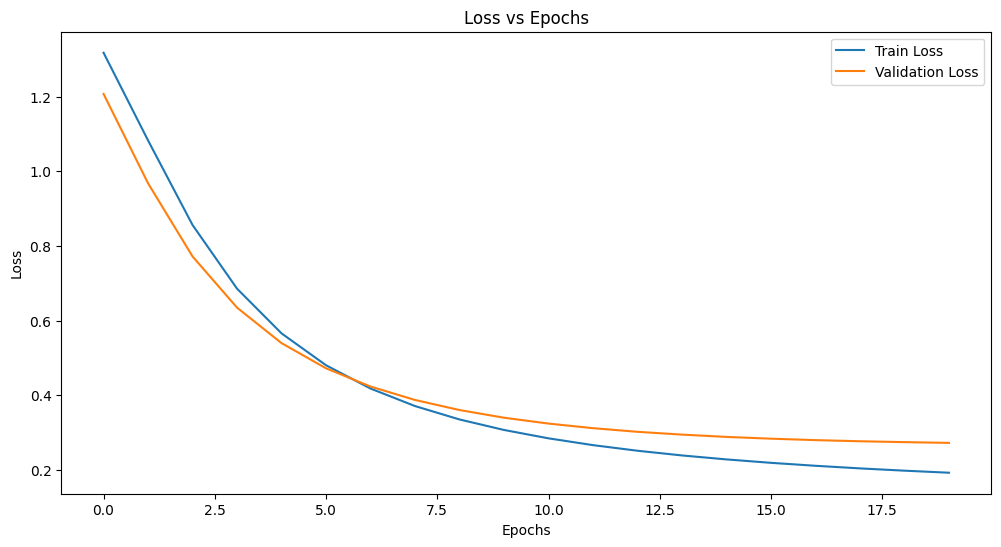

In [ ]:
# Plot the validation and training loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'tweet_model.pth')

## Testing evaluation

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/test_hockey_data.csv')

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
teams = [
    "ducks", "coyotes", "bruins", "sabres", "flames", "hurricanes",
    "blackhawks", "avalanche", "blue jackets", "stars", "red wings",
    "oilers", "panthers", "kings", "wild", "canadiens", "predators",
    "devils", "islanders", "rangers", "senators", "flyers", "penguins",
    "sharks", "kraken", "blues", "lightning", "maple leafs", "canucks",
    "golden knights", "capitals", "jets", "leafs", "knights", "jackets", "wings"
]

teams_with_boundaries = [r'\b' + team + r'\b' for team in teams]

teams_with_boundaries = '|'.join(teams_with_boundaries)

In [ ]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess tweet text for machine learning.

    Done by removing URLs and special characters, tokenizing, removing
    stop words, and lemmatizing the words.
    """

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove "&amp;" an HTML entity
    text = re.sub(r'&amp;', '', text)

    # Remove hockey related words
    text = re.sub(r'\bhockey\b|\bnhl\b|\bv\b|\b'+teams_with_boundaries, '', text, flags=re.IGNORECASE)

    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Initialize the lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Remove stop words and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(token.lower())
        for token in tokens if token.lower() not in stop_words
    ]

    return ' '.join(processed_tokens)

In [ ]:
# process tweets into tokens
test_df['preprocessed_title'] = test_df['title'].apply(preprocess_text)
print(test_df['preprocessed_title'][10:20]) # peek at some tweets

10                      datsyuks first goal 2013 season
11                             game thread game tonight
12                                       bryz echl vega
13    game thread anaheim colorado 2 october 2013 73...
14                                      90 kid get lgrw
15                     there montral speak french crowd
16        restaurant write fodors restaurant koivu bros
17       panoramic shot seat brooklyn v barclays center
18    last april ryan suter averaged 27 minute game ...
19                                 20132014 season know
Name: preprocessed_title, dtype: object


In [ ]:
# apply vectorizer to the test set
X_test = vectorizer.transform(test_df['preprocessed_title'])
X_test = X_test.toarray()
print(X_test.shape) # (number of samples, number of features)

(10001, 5000)


In [ ]:
# classify the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_pred = model(X_test_tensor)
    _, predicted = torch.max(y_test_pred.data, 1)
    test_df['predicted_topic'] = predicted.numpy()  # Convert to numpy array and add to DataFrame

In [ ]:
label_mapping = {0: 'standings/playoff news', 1: 'contract/trade', 2: 'franchise news', 3: 'individual/game news'}
test_df['predicted_topic'] = test_df['predicted_topic'].map(label_mapping)
#

In [ ]:
print(test_df[20:40])

                                                title  created_utc  \
20        kovalchuk may be out for 4 weeks in the khl   1380759068   
21                     coyote's inaugural stick blade   1380758962   
22  can someone please give me a link to watch the...   1380758923   
23                      remember this time last year?   1380758674   
24  hq zdeno chara vs david koci fight october 25,...   1380758652   
25  found this in my buddys basement coyote's inau...   1380758520   
26  undisclosed injury: the scary case of tomas vo...   1380930548   
27  game thread: kings (1-0-0) at jets (1-0-0) - 1...   1380930497   
28       stuff panthers fans are saying after game 1.   1380929334   
29                do you root for more than one team?   1380928903   
30  why does center ice on cable have only 1 hd game?   1380928467   
31  game thread: new york islanders (0-0-0) at new...   1380927281   
32  game thread: red wings (1-0-0) at hurricanes (...   1380927037   
33  john scott: guys

I'm a little fearful that while the model actually performed very well, the topics are poorly defined, which is leading to some of these classifications not make any sense. In retrospect, it might have been better to use sumbissions from r/nhl to narrow things down a little bit in terms of potential post topics.